# Opioid shipping data_plotting

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [191]:
# Load the data
opd_mme_data_raw = pd.read_csv(
    "/Users/ilseoplee/Desktop/Study/2024 MIDS/Practical Data Science/Final_Opioid_Project/20_intermediate_files/shipping_merged_2007_2015.csv"
)
opd_mme_data_raw.describe()

,COUNTY_CODE,YEAR,POPULATION,MME_Conversion_Factor,MME_per_capita
count,5103.000000,5103.000000,5.103000e+03,5.103000e+03,5.103000e+03
mean,25446.700176,2011.000000,1.059234e+05,6.522287e+08,1.637601e+03
std,14921.273578,2.582242,2.280366e+05,1.524537e+10,4.546972e+04
min,8001.000000,2007.000000,4.700000e+02,0.000000e+00,0.000000e+00
25%,13021.000000,2009.000000,1.256550e+04,7.096745e+03,5.328832e-01
50%,13309.000000,2011.000000,2.899900e+04,2.941156e+04,8.754855e-01
75%,37159.000000,2013.000000,9.370700e+04,1.157337e+05,1.371325e+00
max,53077.000000,2015.000000,2.659549e+06,7.400370e+11,2.534742e+06


In [ ]:
# Missing value treatment : drop population below 20K
opd_mme_data = opd_mme_data_raw[opd_mme_data_raw["POPULATION"] > 20000].copy()

# opd_mme_data.head
len(opd_mme_data)

1952

In [ ]:
# MME Multiplier & log transformation
multiplier = 1000000
opd_mme_data["MME_per_capita_multiplier"] = (
    np.log(opd_mme_data["MME_per_capita"] * multiplier) + 1
)
opd_mme_data.head(3)

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,MME_Conversion_Factor,MME_per_capita,MME_per_capita_multiplier
0,COLORADO,CO,ADAMS COUNTY,8001,2007,415746,3.887932e+06,9.351701,17.051069
1,COLORADO,CO,ADAMS COUNTY,8001,2008,424913,3.371338e+06,7.934184,16.886691
2,COLORADO,CO,ADAMS COUNTY,8001,2009,435700,3.159909e+06,7.252488,16.796855


In [ ]:
# FL filtering
fl_data = opd_mme_data[opd_mme_data["STATE"] == "FL"]

# FL data _ MME per capita multiplier
fl_yearly_summary = fl_data.groupby("YEAR")["MME_per_capita"].mean().reset_index()
fl_yearly_summary_1 = (
    fl_data.groupby("YEAR")["MME_per_capita_multiplier"].mean().reset_index()
)

# check
display(fl_yearly_summary)
display(fl_yearly_summary_1)

,YEAR,MME_per_capita
0,2007,17.374513
1,2008,410.537972
2,2009,2723.316794
3,2010,4487.255089
4,2011,1994.266932
5,2012,2083.472727
6,2013,9835.065806
7,2014,10657.195974
8,2015,1326.621854


,YEAR,MME_per_capita_multiplier
0,2007,15.366038
1,2008,15.753852
2,2009,15.621231
3,2010,15.937786
4,2011,15.947576
5,2012,15.852721
6,2013,15.978025
7,2014,15.982371
8,2015,15.890964


In [195]:
def prepare_data(
    dataset,
    testing_state,
    controlling_states,
    pol_impl_year,
    starting_year,
    ending_year,
):
    """
    Parameters:
        dataset (DataFrame): The original dataset to be processed.
        testing_state (str): The state where the policy is implemented (Test state).
        controlling_states (list): List of control states for comparison.
        pol_impl_year (int): The year the policy was implemented.
        starting_year (int): The first year of the analysis period.
        ending_year (int): The last year of the analysis period.
    """

    # Combining test and control states to filter
    relevant_states = [testing_state] + controlling_states

    # Filtering the dataset based on the relevant states and years
    filtered_dataset = dataset[
        (dataset["STATE"].isin(relevant_states))
        & (dataset["YEAR"].between(starting_year, ending_year))
    ].copy()

    # Adding column indicating whether the policy is pre or post implementation
    filtered_dataset["POLICY_IMPLEMENTATION"] = (
        filtered_dataset["YEAR"] >= pol_impl_year
    )

    # Labelling each state as 'Test' or 'Control' based on the provided states
    filtered_dataset["STATE_TYPE"] = filtered_dataset["STATE"].apply(
        lambda state: "Test" if state == testing_state else "Control"
    )

    return filtered_dataset

In [ ]:
def pre_post_plot(dataset_2, testing_state, pol_implem_year, metric_column):
    """
    Parameters:
        dataset_2 (DataFrame): The dataset to be visualized.
        metric_column (str): The column representing the metric to plot ("MORM_MORT_MULT").
    """

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Seting up the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Defining the data for pre-policy and post-policy analysis
    pre_policy_data = dataset[
        (dataset["STATE"] == testing_state)
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    post_policy_data = dataset[
        (dataset["STATE"] == testing_state) & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]

    # Ploting pre-policy trend line
    sns.regplot(
        data=pre_policy_data,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Ploting post-policy trend line
    sns.regplot(
        data=post_policy_data,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Adding a vertical line at the policy implemented year
    ax.axvline(pol_implem_year, ls="--", color="black", label="Policy Implemented Year")

    # Defining the legend
    legend_handles = [
        mlines.Line2D([], [], color="red", label="Post-Policy"),
        mlines.Line2D([], [], color="blue", label="Pre-Policy"),
        mlines.Line2D(
            [], [], color="black", label="Policy Implemented Year", linestyle="--"
        ),
    ]
    ax.legend(handles=legend_handles, loc="lower right")

    # Adding titles and labels
    ax.set_title(f"Pre-Post Analysis for MME_per_1,000,000_people: {testing_state}")
    ax.set_xlabel("Year")
    ax.set_ylabel(f"MME_per_1,000,000_people")

    # Showing the plot
    plt.show()

In [ ]:
def dif_dif_plot(
    dataset_2, testing_state, controlling_state, pol_implem_year, metric_column
):

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Seting up the plot
    fig, ax = plt.subplots(figsize=(8.2, 4))

    # Filtering data for pre- and post-policy periods
    test_state_pre = dataset[
        (dataset["STATE"] == testing_state)
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    test_state_post = dataset[
        (dataset["STATE"] == testing_state) & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]
    control_states_pre = dataset[
        (dataset["STATE"].isin(controlling_state))
        & (dataset["POLICY_IMPLEMENTATION"] == False)
    ]
    control_states_post = dataset[
        (dataset["STATE"].isin(controlling_state))
        & (dataset["POLICY_IMPLEMENTATION"] == True)
    ]

    # Ploting difference-in-difference analysis for testing and controlling states
    sns.regplot(
        data=test_state_pre,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=test_state_post,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=control_states_pre,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )
    sns.regplot(
        data=control_states_post,
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding a vertical line for the policy implementation year
    ax.axvline(pol_implem_year, ls="--", color="black", label="Policy Implemented Year")

    # Adding legend
    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Test State (Pre/Post)"),
            mlines.Line2D([], [], color="red", label="Control States (Pre/Post)"),
            mlines.Line2D([], [], color="black", linestyle="--", label="Policy Year"),
        ],
        loc="lower right",
    )

    # Seting titles and labels
    plt.title(
        f"Difference-in-Difference Analysis for MME_per_1,000,000_people : {testing_state}"
    )
    plt.xlabel("Year")
    plt.ylabel(f"MME_per_1,000,000_people")

    # Showing plot
    plt.show()

In [ ]:
def all_states_plot(dataset_2, pol_implem_year, metric_column):

    # Creating a copy of the dataset to avoid modifying the original DataFrame
    dataset = dataset_2.copy()

    # Creating the lmplot for the dataset with state-wise breakdown
    plot = sns.lmplot(
        data=dataset,
        x="YEAR",
        y=metric_column,
        hue="POLICY_IMPLEMENTATION",
        legend=False,
        row="STATE",
        height=4,
        aspect=1.75,
    )

    # Seting titles for each subplot using the state names
    plot.set_titles("{row_name}", fontsize=12)

    # Adding a vertical line at the policy implementation year
    for ax in plot.axes.flat:
        ax.axvline(
            pol_implem_year,
            ls="--",
            color="black",
            lw=2,
            label="Policy Implementated Year",
        )

    plt.legend(
        loc="lower right",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    # Adjusting labels and add a legend
    plot.set_axis_labels("Year", metric_column, fontsize=12)
    plot.set_ylabels(f"MME_per_1,000,000_people", fontsize=12)

    # Displaying the plot with adjusted layout
    plt.tight_layout()
    plt.show()

In [199]:
# Defining the testing state for the analysis
testing_state = "WA"

# Listing of controlling states for comparison
controlling_states = ["CO", "OR", "MT"]

# Defining key years for the analysis
pol_implem_year = 2012
starting_year = 2008
ending_year = 2015

opd_mme_plot = prepare_data(
    opd_mme_data,
    testing_state,
    controlling_states,
    pol_implem_year,
    starting_year,
    ending_year,
)

opd_mme_plot.head(20)

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,MME_Conversion_Factor,MME_per_capita,MME_per_capita_multiplier,POLICY_IMPLEMENTATION,STATE_TYPE
1,COLORADO,CO,ADAMS COUNTY,8001,2008,424913,3.371338e+06,7.934184,16.886691,False,Control
2,COLORADO,CO,ADAMS COUNTY,8001,2009,435700,3.159909e+06,7.252488,16.796855,False,Control
3,COLORADO,CO,ADAMS COUNTY,8001,2010,443692,2.949082e+06,6.646687,16.709629,False,Control
4,COLORADO,CO,ADAMS COUNTY,8001,2011,452209,3.179628e+06,7.031325,16.765886,False,Control
5,COLORADO,CO,ADAMS COUNTY,8001,2012,460568,2.727763e+06,5.922607,16.594287,True,Control
6,COLORADO,CO,ADAMS COUNTY,8001,2013,469995,3.202421e+06,6.813735,16.734451,True,Control
7,COLORADO,CO,ADAMS COUNTY,8001,2014,479954,5.029745e+06,10.479639,17.164945,True,Control
8,COLORADO,CO,ADAMS COUNTY,8001,2015,490448,3.910921e+05,0.797418,14.589134,True,Control
19,COLORADO,CO,ARAPAHOE COUNTY,8005,2008,552461,1.774565e+06,3.212109,15.982438,False,Control
20,COLORADO,CO,ARAPAHOE COUNTY,8005,2009,563161,2.035225e+06,3.613930,16.100306,False,Control


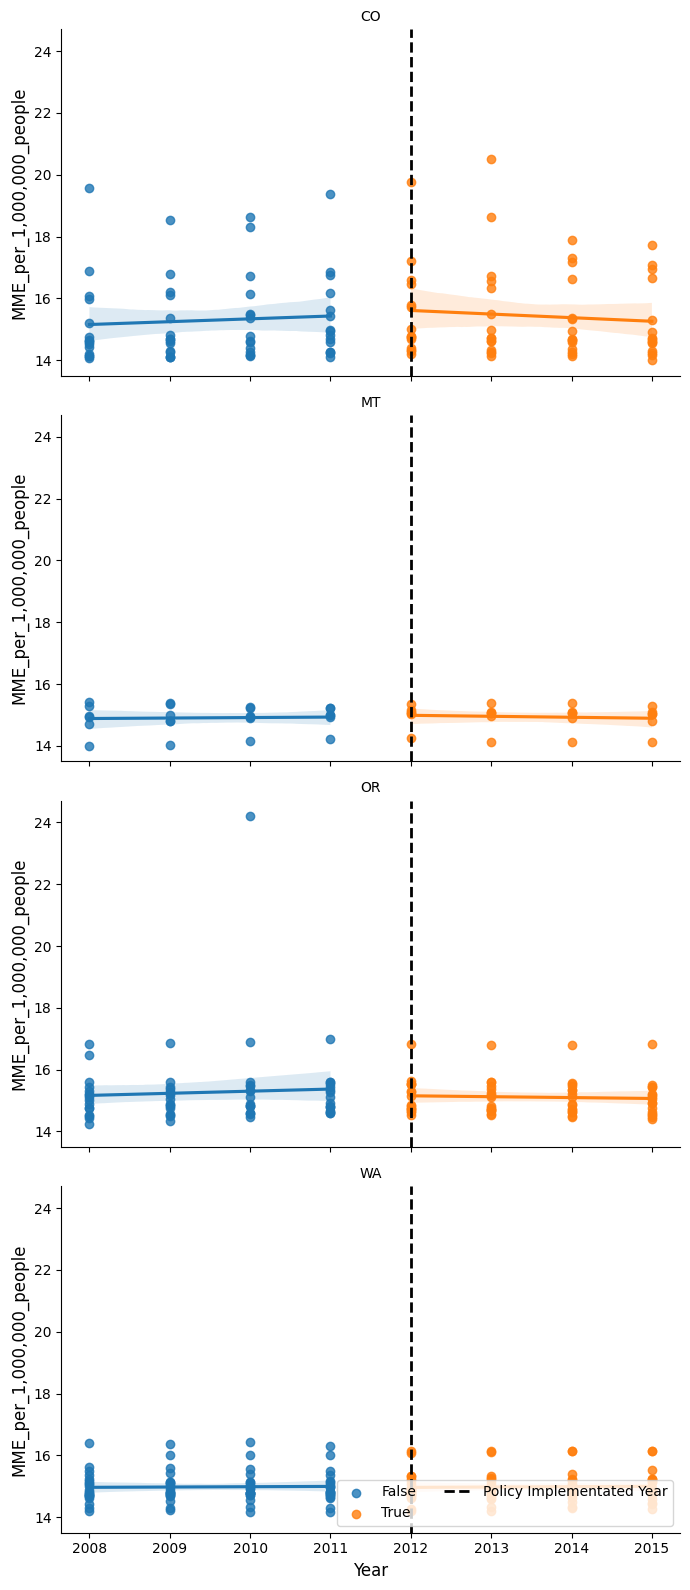

In [200]:
# Calling the all_states_plot function to visualize the data
all_states_plot(opd_mme_plot, pol_implem_year, "MME_per_capita_multiplier")

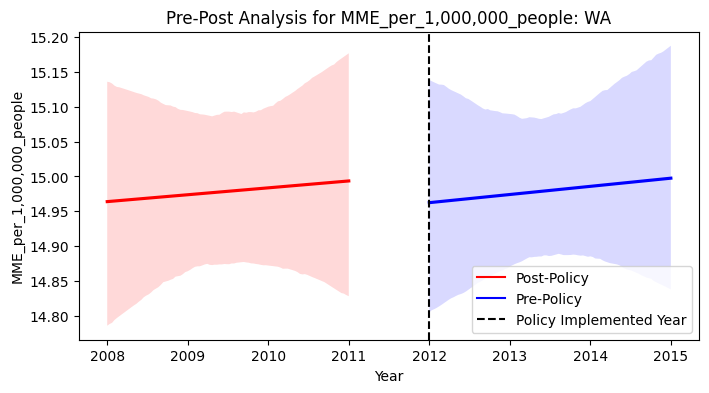

In [201]:
# Calling the pre_post_plot function to visualize pre-post analysis for mortality: FL
pre_post_plot(opd_mme_plot, testing_state, pol_implem_year, "MME_per_capita_multiplier")

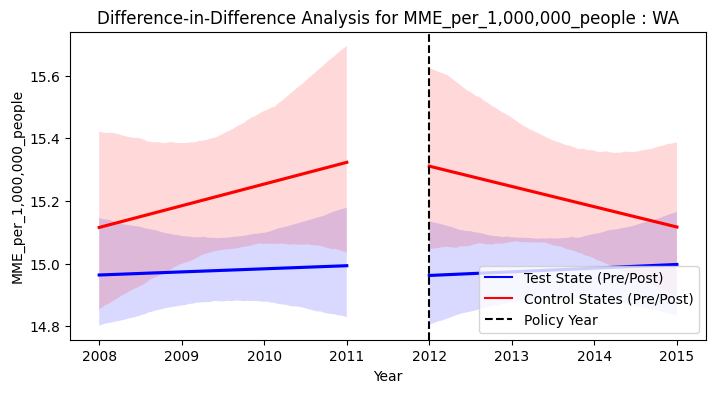

In [ ]:
# Calling the dif_dif_plot function to visualize difference-in-difference analysis for mortality: WA

dif_dif_plot(
    opd_mme_plot,
    testing_state,
    controlling_states,
    pol_implem_year,
    "MME_per_capita_multiplier",
)

### Pre-post Analysis and Difference-in-Difference Analysis for Florida

In [203]:
# Defining the testing state for the analysis
testing_state = "FL"

# Listing of controlling states for comparison
controlling_states = ["GA", "NC", "SC"]

# Defining key years for the analysis
pol_implem_year = 2010
starting_year = 2006
ending_year = 2013

mme_opd_plot = prepare_data(
    opd_mme_data,
    testing_state,
    controlling_states,
    pol_implem_year,
    starting_year,
    ending_year,
)

mme_opd_plot

,STATE_NAME,STATE,COUNTY,COUNTY_CODE,YEAR,POPULATION,MME_Conversion_Factor,MME_per_capita,MME_per_capita_multiplier,POLICY_IMPLEMENTATION,STATE_TYPE
576,FLORIDA,FL,ALACHUA COUNTY,12001,2007,242685,381327.484369,1.571286,15.267405,False,Test
577,FLORIDA,FL,ALACHUA COUNTY,12001,2008,244888,475070.355203,1.939950,15.478173,False,Test
578,FLORIDA,FL,ALACHUA COUNTY,12001,2009,246657,496969.628700,2.014821,15.516041,False,Test
579,FLORIDA,FL,ALACHUA COUNTY,12001,2010,247624,504114.447649,2.035806,15.526402,True,Test
580,FLORIDA,FL,ALACHUA COUNTY,12001,2011,249879,508708.247867,2.035818,15.526408,True,Test
...,...,...,...,...,...,...,...,...,...,...,...
4745,SOUTH CAROLINA,SC,YORK COUNTY,45091,2009,223616,95521.975200,0.427170,13.964937,False,Control
4746,SOUTH CAROLINA,SC,YORK COUNTY,45091,2010,226871,118222.683800,0.521101,14.163699,True,Control
4747,SOUTH CAROLINA,SC,YORK COUNTY,45091,2011,230131,125816.897187,0.546719,14.211689,True,Control
4748,SOUTH CAROLINA,SC,YORK COUNTY,45091,2012,234151,166831.477725,0.712495,14.476529,True,Control


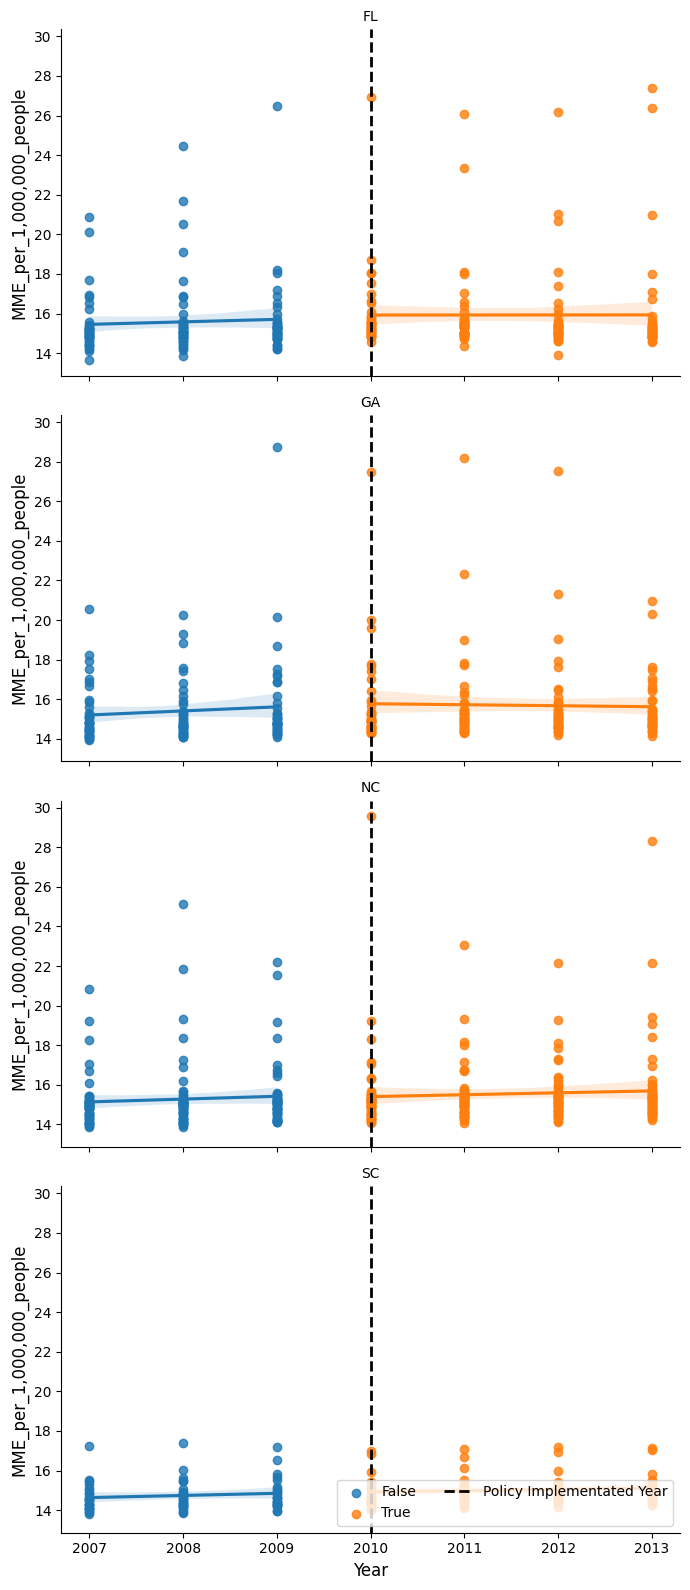

In [204]:
# Calling the all_states_plot function to visualize the data
all_states_plot(mme_opd_plot, pol_implem_year, "MME_per_capita_multiplier")

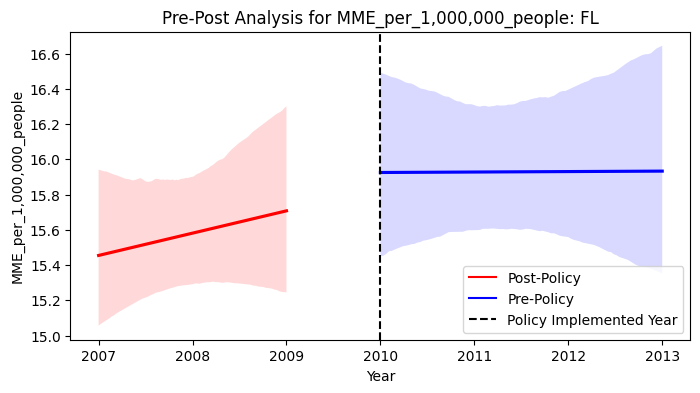

In [205]:
# Calling the pre_post_plot function to visualize pre-post analysis for mortality: FL
pre_post_plot(mme_opd_plot, testing_state, pol_implem_year, "MME_per_capita_multiplier")

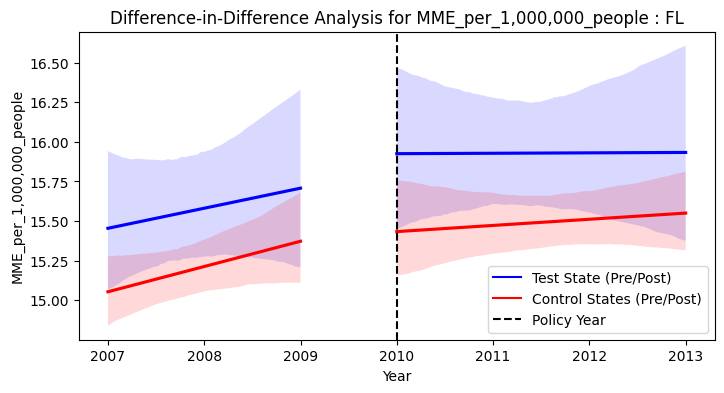

In [ ]:
# Calling the dif_dif_plot function to visualize difference-in-difference analysis for mortality: FL
dif_dif_plot(
    mme_opd_plot,
    testing_state,
    controlling_states,
    pol_implem_year,
    "MME_per_capita_multiplier",
)